In [5]:
# This Notebook calculates the effective area

In [49]:
# Parameters

indir = "../../data/"
infile = ['pyirf_eventdisplay.fits.gz',"DESY.d20180113.V3.ID0_180degNIM2LST4MST4SST4SCMST4.prod3b-paranal20degs05b-NN.S.3HB9-FD.180000s.root"]
outfile = None
key_suffix = '' # e.g. '_NO_CUTS', '_ONLY_GH', '_ONLY_THETA' for pyirf
requirement = indir+'South-EffectiveArea.txt'
plot_only=True

In [50]:
import os

import numpy as np
import uproot
from astropy.io import fits
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.table import QTable

%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [51]:
# Creat files for Effective Area

if not plot_only:
    for f in infile:
        if f.endswith('.root'):
            # Data from EventDisplay
            irf_eventdisplay = uproot.open(os.path.join(indir, f))
            h = irf_eventdisplay["EffectiveAreaEtrue"]

            x = 0.5 * (10**h.edges[:-1] + 10**h.edges[1:])
            y = h.values
            xerr = 0.5 * np.diff(10**h.edges)
            yerr = np.sqrt(h.variances)

            t = QTable([x,y,xerr,yerr], names=['x','y','xerr','yerr'])
            t.write(os.path.join(indir, f.strip('.root')+'_EffectiveArea.csv'), format='csv')

        elif f.endswith('.fits.gz'):
            # Data from pyIRF
            area = QTable.read(os.path.join(indir, f), hdu='EFFECTIVE_AREA' + key_suffix)[0]

            x = 0.5 * (area['ENERG_LO'] + area['ENERG_HI']).to_value(u.TeV)[1:-1]
            y = area['EFFAREA'].to_value(u.m**2).T[1:-1, 0]
            xerr = 0.5 * (area['ENERG_LO'] - area['ENERG_HI']).to_value(u.TeV)[1:-1]
            yerr = np.zeros(len(xerr))

            t = QTable([x,y,xerr,yerr], names=['x','y','xerr','yerr'])
            t.write(os.path.join(indir, f.strip('.fits.gz')+'_EffectiveArea.csv'), format='csv')
        else:
            print('Reader not implemented, please include own reader')

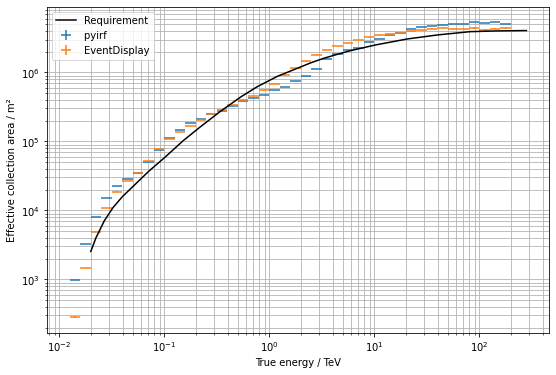

In [52]:
# Plotting

for f in infile:
    if f.endswith('.root'):
        t = QTable.read(os.path.join(indir,f.strip('.root')+'_EffectiveArea.csv'))
        plt.errorbar(t['x'], t['y'], xerr=t['xerr'], yerr=t['yerr'], ls='', label="EventDisplay")
        
    elif f.endswith('.fits.gz'):
        t = QTable.read(os.path.join(indir,f.strip('.fits.gz')+'_EffectiveArea.csv'))
        plt.errorbar(t['x'], t['y'], xerr=t['xerr'], yerr=t['yerr'],ls='', label='pyirf ' + key_suffix)
    
    
if requirement is not None:
    r = np.loadtxt(requirement, unpack=True)
    plt.plot(10**r[0], r[1], color='k', label='Requirement')
    
# Style settings
plt.xscale("log")
plt.yscale("log")
plt.xlabel("True energy / TeV")
plt.ylabel("Effective collection area / m²")
plt.grid(which="both")
plt.legend()

None # to remove clutter by mpl objects